In [1]:
# # Visualize it
%matplotlib ipympl
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from ipywidgets import interactive, widgets
from mpl_toolkits.mplot3d import Axes3D


def generate_sphere(center: tuple[int, int, int], radius: int, shape: tuple[int, int, int]) -> np.ndarray:
	"""
	Create a spherical object inside a 3D NumPy array.
	
	Parameters
	----------
	center : tuple[int, int, int]
		Center of the sphere (x, y, z).
	radius : int
		Radius of the sphere.
	shape : tuple[int, int, int]
		Shape of the 3D array.
		
	Returns
	-------
	np.ndarray
		A 3D array with 1s inside the sphere and 0s elsewhere.
	"""
	x, y, z = np.indices(shape)
	sphere = (x - center[0]) ** 2 + (y - center[1]) ** 2 + (z - center[2]) ** 2 <= radius ** 2
	return sphere.astype(np.uint8)

def generate_duck(shape: tuple[int, int, int]) -> np.ndarray:
	"""
	Generate a voxel representation of a rubber duck.

	Parameters
	----------
	shape : tuple[int, int, int]
		Shape of the 3D array.

	Returns
	-------
	np.ndarray
		3D array representing the duck.
	"""
	duck = np.zeros(shape, dtype=np.uint8)

	# Body (main sphere)
	duck += generate_sphere((30, 30, 30), 20, shape)

	# Head (smaller sphere on top)
	duck += generate_sphere((40, 30, 40), 10, shape)

	# Beak (flattened sphere)
	duck += generate_sphere((47, 30, 40), 5, shape) * (np.indices(shape)[0] > 42)

	# Tail (small sphere in the back)
	duck += generate_sphere((15, 30, 30), 7, shape)

	# Wings (ellipsoidal shapes)
	wing_left = generate_sphere((30, 45, 30), 8, shape) * (np.indices(shape)[1] < 40)
	wing_right = generate_sphere((30, 15, 30), 8, shape) * (np.indices(shape)[1] > 20)
	duck += wing_left + wing_right

	# Internal "cancer-like" structure (star shape)
	cancer = np.zeros(shape, dtype=np.uint8)
	for i in range(-2, 3):
		cancer += generate_sphere((30 + i * 2, 30, 30), 3, shape)
		cancer += generate_sphere((30, 30 + i * 2, 30), 3, shape)
		cancer += generate_sphere((30, 30, 30 + i * 2), 3, shape)

	# Merge cancer into the duck
	# duck = np.clip(duck + cancer * 2, 0, 2)  # Duck=1, Cancer=2

	
	return duck



In [2]:
import numpy as np
import plotly.graph_objects as go


def plot_3d_voxels(duck: np.ndarray):
	"""
	Visualize the 3D rubber duck using Plotly Scatter3d.

	Parameters
	----------
	duck : np.ndarray
		3D array representing the duck.
	"""
	# Extract voxel positions where duck exists
	x, y, z = np.where(duck > 0)
	values = duck[x, y, z]  # Extract voxel values for coloring

	# Map voxel values to colors
	colors = np.array(["yellow" if v == 1 else "red" for v in values])

	# Create a 3D scatter plot
	fig = go.Figure(data=go.Scatter3d(
		x=x, y=y, z=z,
		mode='markers',
		marker=dict(
			size=5,  # Size of each voxel
			color=colors,  # Color based on voxel type
			opacity=0.7  # Transparency
		)
	))

	# Adjust layout
	fig.update_layout(scene=dict(
		xaxis=dict(nticks=10, range=[0, duck.shape[0]]),
		yaxis=dict(nticks=10, range=[0, duck.shape[1]]),
		zaxis=dict(nticks=10, range=[0, duck.shape[2]]),
	),
	title="3D Voxelized Rubber Duck"
	)
	
	fig.show()

# Call the function to visualize the duck
# plot_3d_voxels(duck)

Voxel array shape: (69, 95, 89)
Unique values: [0 1]


IntSlider(value=10, description='X Slice:', max=68)

IntSlider(value=10, description='Y Slice:', max=94)

IntSlider(value=10, description='Z Slice:', max=88)

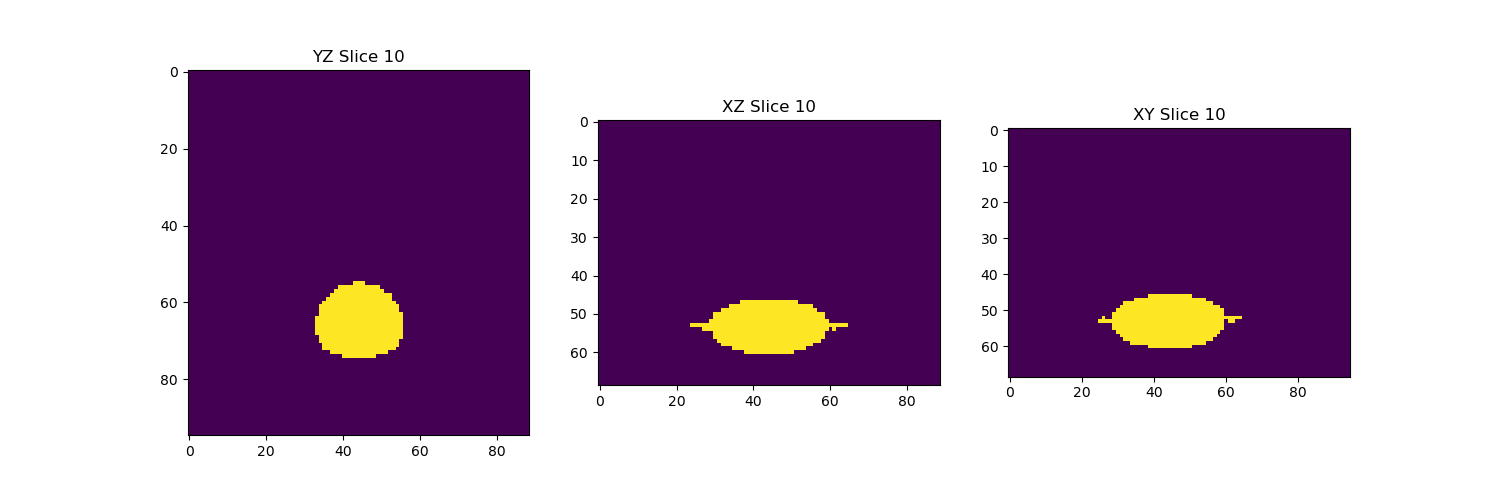

In [3]:
import numpy as np
import trimesh
from scipy.ndimage import binary_fill_holes

# from skimage.morphology import binary_fill_holes
from skimage.segmentation import flood_fill


def mesh_to_voxels(filepath: str, resolution: int = 512, pad : int = 5) -> np.ndarray:
	"""
	Load a 3D model and convert it to a filled voxel representation.

	Parameters
	----------
	filepath : str
		Path to the .glb or .gltf file.
	resolution : int, optional
		Resolution of the voxel grid (higher = finer details).

	Returns
	-------
	np.ndarray
		3D numpy array with 1s inside the object and 0s outside.
	"""
	# Load mesh
	mesh = trimesh.load_mesh(filepath)

	# Get voxel grid
	voxel_grid = mesh.voxelized(pitch=mesh.scale / resolution)
	# Convert to a NumPy array
	voxel_array = voxel_grid.matrix.astype(np.uint8)
	# Fill internal holes to make the duck solid
	voxel_filled = binary_fill_holes(voxel_array).astype(np.uint8)

	# rotate counterclockwise along z-axis
	voxel_filled = np.rot90(voxel_filled, 1, (0, 1))

	voxel_padded = np.pad(voxel_filled, pad_width=pad, mode="constant", constant_values=0)
	final_array = voxel_padded
	return final_array

def visualize_voxel_slices(voxel_array: np.ndarray) -> None:
	slice_max_x = voxel_array.shape[0] - 1
	slice_max_y = voxel_array.shape[1] - 1
	slice_max_z = voxel_array.shape[2] - 1

	# Create slider widgets for each axis
	slice_slider_x = widgets.IntSlider(
		value=10, min=0, max=slice_max_x, step=1, 
		description='X Slice:', orientation='horizontal'
	)
	slice_slider_y = widgets.IntSlider(
		value=10, min=0, max=slice_max_y, step=1, 
		description='Y Slice:', orientation='horizontal'
	)
	slice_slider_z = widgets.IntSlider(
		value=10, min=0, max=slice_max_z, step=1, 
		description='Z Slice:', orientation='horizontal'
	)

	fig, axs = plt.subplots(1, 3, figsize=(15, 5))
	image_array = voxel_array

	# Define a function to update the visualization based on the slider values
	def update_slices(change) -> None:
		slice_index_x = slice_slider_x.value
		slice_index_y = slice_slider_y.value
		slice_index_z = slice_slider_z.value

		# Update the images for each view
		axs[0].imshow(image_array[slice_index_x, :, :])
		axs[0].set_title(f"YZ Slice {slice_index_x}")

		axs[1].imshow(image_array[:, slice_index_y, :])
		axs[1].set_title(f"XZ Slice {slice_index_y}")

		axs[2].imshow(image_array[:, :, slice_index_z])
		axs[2].set_title(f"XY Slice {slice_index_z}")

	# Attach the update function to the sliders
	slice_slider_x.observe(update_slices, names='value')
	slice_slider_y.observe(update_slices, names='value')
	slice_slider_z.observe(update_slices, names='value')

	# Display the initial images
	update_slices(None)

	# Display the sliders
	display(slice_slider_x, slice_slider_y, slice_slider_z)

# Example usage
voxel_array = mesh_to_voxels("rubber_inflatable_duck.glb", resolution=128)

print(f"Voxel array shape: {voxel_array.shape}")
print(f"Unique values: {np.unique(voxel_array)}") 

visualize_voxel_slices(voxel_array)

self.resolution=(69, 95, 89)


IntSlider(value=34, description='X Slice (68 total):', max=68)

IntSlider(value=47, description='Y Slice (94 total):', max=94)

IntSlider(value=44, description='Z Slice (88 total):', max=88)

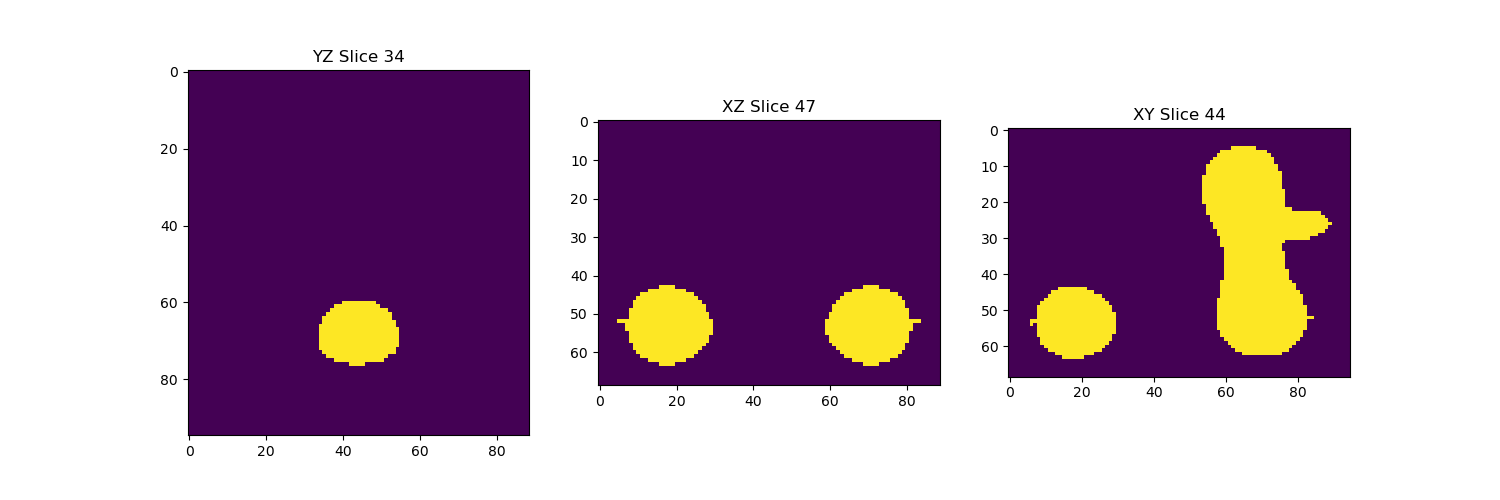

In [5]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import trimesh
from IPython.display import display
from scipy.ndimage import binary_fill_holes


class VoxelVisualizer:
  """
  Class for visualizing voxelized 3D models with precomputed slices.

  Attributes
  ----------
  voxel_array : np.ndarray
    3D numpy array representing the filled voxel model.
  slices_x : list of np.ndarray
    Precomputed YZ slices along the X-axis.
  slices_y : list of np.ndarray
    Precomputed XZ slices along the Y-axis.
  slices_z : list of np.ndarray
    Precomputed XY slices along the Z-axis.
  """
  def __init__(self, voxel_array: np.ndarray) -> None:
    """
    Initialize the voxel visualizer with a precomputed voxel array
    and precompute 2D slice images.

    Parameters
    ----------
    voxel_array : np.ndarray
      3D numpy array representing the filled voxel model.
    """
    self.voxel_array = voxel_array
    self.slices_x = [self.voxel_array[i, :, :] for i in range(self.voxel_array.shape[0])]
    self.slices_y = [self.voxel_array[:, i, :] for i in range(self.voxel_array.shape[1])]
    self.slices_z = [self.voxel_array[:, :, i] for i in range(self.voxel_array.shape[2])]

    # calculate 3D resolution
    self.resolution = self.voxel_array.shape
    print(f"{self.resolution=}")

  def _mesh_to_voxels(self, filepath: str, resolution: int, pad: int) -> np.ndarray:
    """
    Convert a 3D mesh to a filled voxel representation.

    Returns
    -------
    np.ndarray
      3D numpy array with 1s inside the object and 0s outside.
    """
    mesh = trimesh.load_mesh(filepath)
    voxel_grid = mesh.voxelized(pitch=mesh.scale / resolution)
    voxel_array = voxel_grid.matrix.astype(np.uint8)
    voxel_filled = binary_fill_holes(voxel_array).astype(np.uint8)
    voxel_filled = np.rot90(voxel_filled, 1, (0, 1))  # Rotate for better alignment
    return np.pad(voxel_filled, pad_width=pad, mode="constant", constant_values=0)

  def visualize(self)-> None:
    """
    Display an interactive widget for selecting precomputed slices.
    """
    slice_max_x, slice_max_y, slice_max_z = (
      self.voxel_array.shape[0] - 1,
      self.voxel_array.shape[1] - 1,
      self.voxel_array.shape[2] - 1
    )
    x_start, y_start, z_start = (
      slice_max_x // 2,
      slice_max_y // 2,
      slice_max_z // 2
    )
    # Sliders
    slice_slider_x = widgets.IntSlider(value=x_start, min=0, max=slice_max_x, step=1, description=f"X Slice ({slice_max_x} total):")
    slice_slider_y = widgets.IntSlider(value=y_start, min=0, max=slice_max_y, step=1, description=f"Y Slice ({slice_max_y} total):")
    slice_slider_z = widgets.IntSlider(value=z_start, min=0, max=slice_max_z, step=1, description=f"Z Slice ({slice_max_z} total):")

    # Matplotlib figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    def update_slices(change=None)-> None:
      axs[0].imshow(self.slices_x[slice_slider_x.value],)
      axs[0].set_title(f"YZ Slice {slice_slider_x.value}")

      axs[1].imshow(self.slices_y[slice_slider_y.value],)
      axs[1].set_title(f"XZ Slice {slice_slider_y.value}")

      axs[2].imshow(self.slices_z[slice_slider_z.value],)
      axs[2].set_title(f"XY Slice {slice_slider_z.value}")

      plt.draw()

    # Observe slider changes
    slice_slider_x.observe(update_slices, names="value")
    slice_slider_y.observe(update_slices, names="value")
    slice_slider_z.observe(update_slices, names="value")

    # Initial plot
    update_slices()

    display(slice_slider_x, slice_slider_y, slice_slider_z)


# Example usage
visualizer = VoxelVisualizer(voxel_array) 

visualizer.visualize()